In [18]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Imports

In [19]:
# !pip install --upgrade https://github.com/google-deepmind/nuclease-design.git


In [20]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import pandas as pd

from nuclease_design import amino_acids
from nuclease_design import constants
from nuclease_design import plotting
from nuclease_design import utils


In [21]:
RANDOM_SEED = 0
DATA_DIR = constants.DATA_DIR

# Load data

In [22]:
df = utils.load_all_data()

In [23]:
df = utils.expand_sublibraries(df)

In [24]:
ml_df = df[df['sublibrary_name'] == 'g4_mbo_dnn'].copy()
hr_df = df[df['sublibrary_name'] == 'g4_hit_recombination'].copy()

# Count # of hits

In [25]:
cols_to_show = ['mutations', 'num_mutations']
fiducial = 'a73r'
activity_column = f'activity_greater_than_{fiducial}'
print(hr_df[hr_df[activity_column]].shape[0])
hr_df[hr_df[activity_column]][cols_to_show]

5


,mutations,num_mutations
53135,"((A, 63, S), (A, 73, R))",2
53219,"((S, 55, R), (A, 63, S), (A, 73, I), (D, 74, P))",4
53231,"((A, 34, S), (A, 63, S), (A, 73, I), (D, 74, P))",4
53396,"((A, 34, S), (A, 63, S), (G, 72, K), (A, 73, I...",5
53694,"((A, 34, S), (A, 44, I), (A, 63, P), (D, 64, S...",6


In [26]:
print(ml_df[ml_df[activity_column]].shape[0])
ml_df[ml_df[activity_column]][cols_to_show]


29


,mutations,num_mutations
54680,"((D, 38, N), (A, 63, S), (A, 73, I), (D, 74, P))",4
54696,"((S, 45, T), (A, 63, S), (A, 73, I), (D, 74, P))",4
54714,"((A, 63, S), (D, 74, P), (K, 75, A), (Q, 78, W...",5
54767,"((A, 34, E), (Y, 41, V), (A, 63, S), (A, 73, R...",6
54825,"((S, 45, G), (S, 55, A), (A, 60, Q), (A, 63, S...",8
54827,"((D, 38, E), (Y, 41, L), (S, 45, K), (S, 55, R...",8
54875,"((A, 34, E), (S, 55, R), (A, 63, P), (D, 64, A...",9
54886,"((Y, 41, V), (S, 55, R), (K, 59, S), (A, 60, K...",9
54903,"((A, 34, E), (D, 38, Y), (Y, 41, V), (S, 45, T...",9
54935,"((D, 38, E), (S, 45, Q), (S, 55, A), (K, 59, A...",9


# Count number of mutations discovered

In [27]:
plotting.make_mutation_heatmap_grid(hr_df, ml_df, 'HR', 'ML', parent_sequence=constants.FULL_REFERENCE_SEQ, fiducial='a73r', palette=[plotting.HR_COLOR, plotting.ML_COLOR])

# Alignment plot helpers

In [ ]:
def calculate_entropy(column):
    counts = {}
    for symbol in column:
        if symbol in counts:
            counts[symbol] += 1
        else:
            counts[symbol] = 1
    probabilities = pd.Series(counts).value_counts(normalize=True)
    return scipy.stats.entropy(probabilities, base=2)

def get_entropies(alignment):
    num_positions = len(alignment[0])
    entropies = []

    for position in range(num_positions):
        column = alignment[:, position].upper()  # ensure all tokens are upper case
        entropy = calculate_entropy(column)
        entropies.append(entropy)

    return entropies

In [ ]:
sns.set_style('ticks')

In [ ]:
VARIABLE_START = constants.G4_N_DESIGN_SEQUENCE_START # zero-indexed, inclusive
VARIABLE_END = constants.G4_C_DESIGN_SEQUENCE_END  # zero-indexed, exclusive

In [ ]:
with utils.open_file(constants.ALIGNMENT_PATH, 'r', DATA_DIR) as f:
  alignment = AlignIO.read(handle=f, format='fasta')

In [ ]:
%%time
entropies = np.array(get_entropies(alignment))

CPU times: user 3.27 s, sys: 48.2 ms, total: 3.32 s
Wall time: 3.29 s


In [ ]:
def plot_entropies(entropies, alignment, ax):
  GAP_TOKENS = ['-', '.']
  non_gap_positions = [i for i, aa in enumerate(alignment[0].seq) if aa not in GAP_TOKENS]
  non_gap_entropies = entropies[non_gap_positions]

  positions = np.arange(len(non_gap_positions))

  variable_positions = positions[VARIABLE_START:VARIABLE_END]
  one_indexed_variable_positions = variable_positions + 1
  variable_region_entropies = non_gap_entropies[VARIABLE_START:VARIABLE_END]
  ax.step(one_indexed_variable_positions, variable_region_entropies, color='black', where='pre', linewidth=2)


Text(0, 0.5, 'entropy')

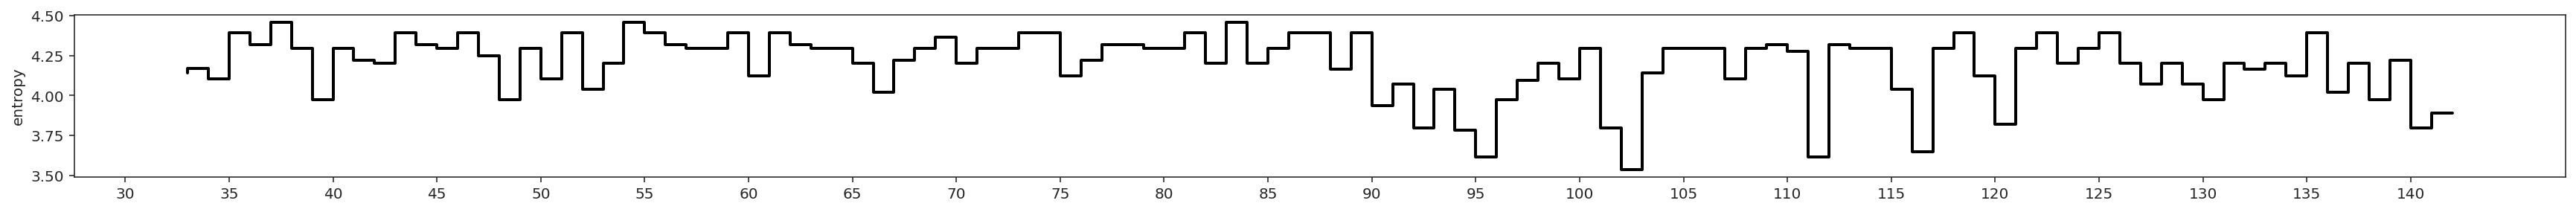

In [ ]:
fig, ax = plt.subplots(figsize=(30, 2), dpi=1000)

plot_entropies(entropies, alignment, ax)
# _ = plt.xticks(np.arange(0, len(non_gap_perplexities), 5))
# plt.xlim(left=VARIABLE_START, right=VARIABLE_END - 0.5)
xticks = np.arange(30, 145, 5)
plt.xticks(xticks)
plt.ylabel('entropy')

# Secondary structure

In [ ]:
def plot_secondary_structure(ax):
  alpha_value = 0
  beta_value = 1
  other_value = 2

  values = []
  # pad the beginning
  for _ in range(0, VARIABLE_START + 1):
    values.append(other_value)

  for i in range(VARIABLE_START + 1, VARIABLE_END + 1):
    ss = constants.get_secondary_structure(i)
    if not ss:
      values.append(other_value)
    else:
      if ss.startswith('alpha'):
        values.append(alpha_value)
      elif ss.startswith('beta'):
        values.append(beta_value)

  neutral_color = (239 / 255, 198 / 255, 158 / 255) # beige
  beta_color = (240 /255, 76 / 255, 75 / 255)  # red
  alpha_color = (61 / 255, 127 / 255, 194 / 255)  # blue
  cmap = sns.color_palette([alpha_color, beta_color, neutral_color], as_cmap=True)

  ss_values = np.expand_dims(values, axis=0)
  sns.heatmap(ss_values, cmap=cmap, ax=ax, cbar=False)
  ax.set_yticks([])

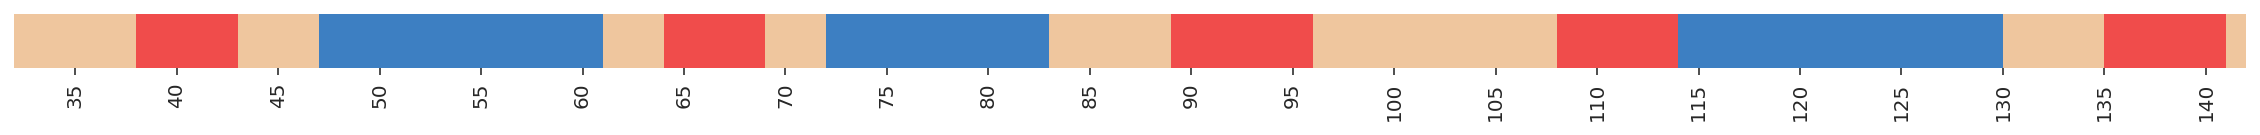

In [ ]:
fig, ax = plt.subplots(figsize=(20, 0.5), nrows=1, ncols=1)
plot_secondary_structure(ax)
_ = ax.set_xticks(ticks=xticks, labels=xticks)
_ = ax.set_xlim(left=VARIABLE_START, right=VARIABLE_END)

# Mega plot

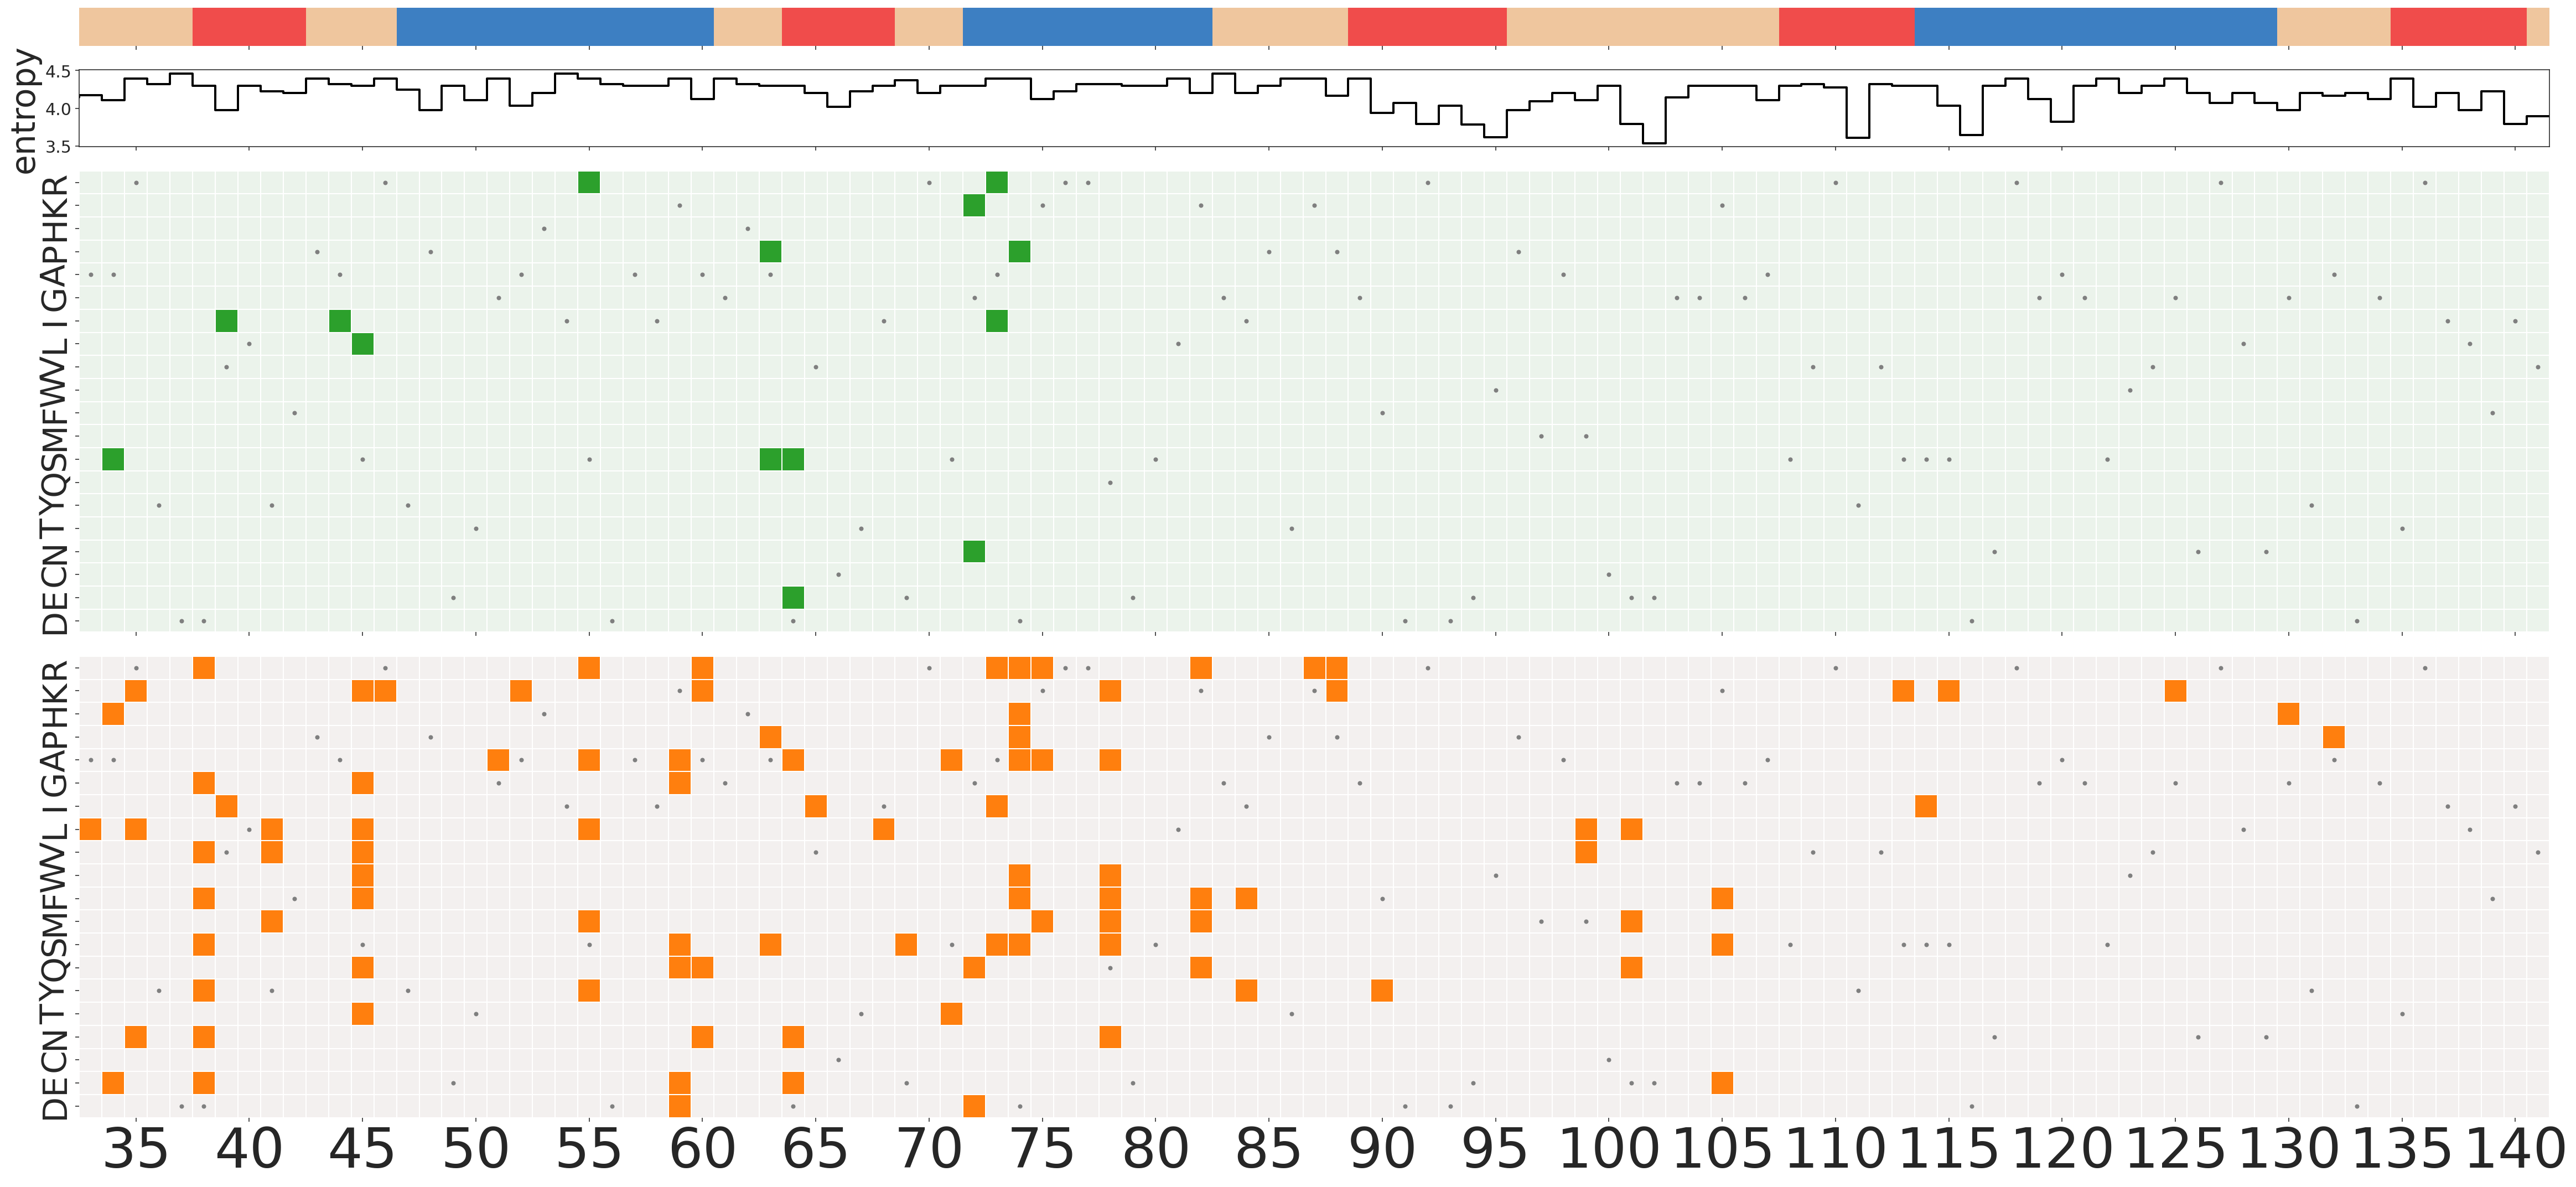

In [ ]:
fig, axs = plt.subplots(
    figsize=(65 / 2, 15),
    nrows=4,
    ncols=1,
    sharex=True,
    height_ratios=[0.25, 0.5, 3, 3],
    dpi=1000,
)

# secondary structure
i = 0
ax = axs[i]
plot_secondary_structure(ax)


# entropy
i = 1
ax = axs[i]
plot_entropies(entropies, alignment, ax)
ax.set_ylabel('entropy', fontsize=30)
ax.yaxis.set_tick_params(labelsize=15)


i = 2
colors = [plotting.HR_COLOR, plotting.ML_COLOR]
for j, plotdf in enumerate([hr_df, ml_df]):
  ax = axs[j + i]
  color = colors[j]
  df_to_plot = plotting._select_hits_at_threshold(plotdf, threshold='a73r')
  plotting.make_mutation_heatmap(
      mutations=df_to_plot['mutations'].explode().dropna(),
      ax=ax,
      use_y_ticks=True,
      use_x_ticks=True,
      inclusive_one_indexed_position_start=VARIABLE_START + 1,
      exclusive_one_indexed_position_end=VARIABLE_END + 1,
      color=color,
      parent_sequence=constants.FULL_REFERENCE_SEQ,
  )
  ax.yaxis.set_tick_params(labelsize=30)
  ax.xaxis.set_tick_params(labelsize=50)

_ = plt.xlim(left=VARIABLE_START + 1, right=VARIABLE_END)
plt.tight_layout()

# Colorbar for charge

In [ ]:
pd.DataFrame.from_dict(amino_acids.AA_TO_ISOELECTRIC_POINT, orient='index', columns=['pI']).sort_values(by='pI', ascending=False)

,pI
R,10.76
K,9.47
H,7.64
P,6.30
A,6.11
G,6.06
I,6.04
L,6.04
V,6.02
W,5.88
